In [13]:
#packages
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import requests
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import shap
from scipy.stats import uniform, randint
import plotly.express as px
import matplotlib.pylab as pl
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import re 
from collections import defaultdict


In [ ]:

# load dataframe
df=pd.read_csv("Dataset_for_model.csv")

#values to 1 -> dummies
df['engineering and technology'] = (df['engineering and technology'] > 0).astype(int)
df['agricultural sciences'] = (df['agricultural sciences'] > 0).astype(int)
df['humanities'] = (df['humanities'] > 0).astype(int)
df['medical and health sciences'] = (df['medical and health sciences'] > 0).astype(int)
df['natural sciences'] = (df['natural sciences'] > 0).astype(int)
df['social sciences'] = (df['social sciences'] > 0).astype(int)
print(df.head(n=10))

# Define bins
df['ecMaxClass'] = pd.qcut(df['ecMaxContribution'], q=10, labels=False, duplicates='drop')

#preprocessing
num_features = ['duration', 'contributors','month', 'agricultural sciences', 'engineering and technology', 
                'humanities', 'medical and health sciences', 
                'natural sciences', 'social sciences'
                ]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), #completing missing values with a median
    #('scaler', StandardScaler()) #standardize all observations
])

cat_features = ['fundingScheme', 'country', 'activityType']


categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')) #makes a category for each combination of the exstin gcategorical variables
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

#XGBoost classifier
xgb = XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Final pipeline
pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)), #synthetic minority oversampling technique
    ('clf', xgb)
])

#parameter griid for grid_search
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Split
train = df[df['split'] == 'train'].copy()
test = df[df['split'] == 'test'].copy()

X_train = train[num_features + cat_features]
y_train = train['ecMaxClass']
X_test = test[num_features + cat_features]
y_test = test['ecMaxClass']

#train
model=grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Predict
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



   agricultural sciences  engineering and technology  humanities  \
0                      0                           0           0   
1                      0                           0           1   
2                      1                           0           0   
3                      0                           0           0   
4                      0                           0           0   
5                      0                           1           0   
6                      0                           1           0   
7                      0                           0           0   
8                      0                           1           0   
9                      0                           0           0   

   medical and health sciences  natural sciences  social sciences  \
0                            0                 1                0   
1                            1                 1                0   
2                            0              

KeyboardInterrupt: 

In [8]:
best_parameters=model.best_estimator_
processor=best_parameters.named_steps['preprocess']
best_model=best_parameters.named_steps['clf']



In [9]:
#SMOTE had to be left out when creating shapley values

x_transformed= processor.transform(X_train)
if hasattr(x_transformed, "toarray"):
    x_transformed=x_transformed.toarray()


In [6]:
#compute SHAP values

masker = shap.maskers.Independent(x_transformed)
explainer= shap.Explainer(best_model, masker)
shap_values= explainer(x_transformed)


100%|===================| 122652/122710 [28:56<00:00]        

In [7]:
#shap values opslaan in apart document zodat niet altijd opnieuw moet runnen
np.save("shap_values.npy", shap_values.values)

In [11]:
#get feature names after preprocessing
feature_names=processor.get_feature_names_out()

In [4]:
shap_values=np.load("shap_values.npy")

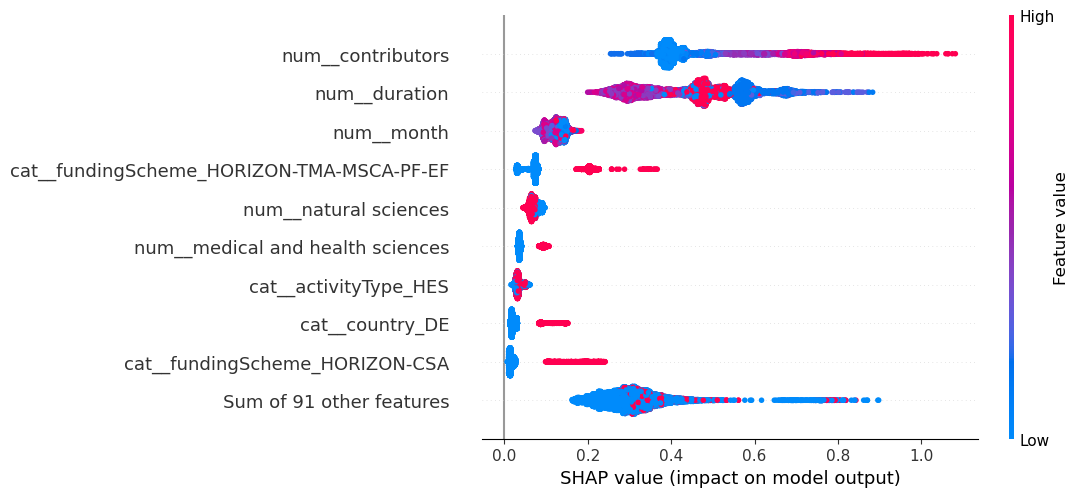

In [12]:

shap_values_mean_overclasses=np.mean(np.abs(shap_values), axis=2)

#mean of shap values over sample and classes and categories of one feature

#explanation object for plotting
shap_expl_obj= shap.Explanation(
    values=shap_values_mean_overclasses,
    data=x_transformed,
    feature_names=feature_names
)


#plot beeswarm
shap.plots.beeswarm(shap_expl_obj)

In [45]:


# Example: original one-hot feature names
# feature_names = shap_values.feature_names or your list of encoded feature names

# Dictionary to hold original feature groups
original_feature_map = defaultdict(list)
num_field='field'
num_duration= "duration" 
num_contributors="contributors"
num_month= "month"

# Group by the prefix before the second underscore (e.g., "cat_FundingScheme")
for f in feature_names:
    # Match pattern: cat_<OriginalFeature>_<Category>
    match = re.match(r"cat__([^_]+)_.*", f)
    if match:
        key = match.group(1)  # extract original feature name (e.g., FundingScheme)
    else:
        if f == "num__duration" :
            key = num_duration # probably a numerical or non-encoded feature
        elif f == "num__contributors":
            key= num_contributors
        elif f=="num__month":
            key= num_month
        else:
            key=num_field
       
    original_feature_map[key].append(f)

# Preview the mapping:
for k, v in original_feature_map.items():
    print(f"{k}: {v}")


duration: ['num__duration']
contributors: ['num__contributors']
month: ['num__month']
field: ['num__agricultural sciences', 'num__engineering and technology', 'num__humanities', 'num__medical and health sciences', 'num__natural sciences', 'num__social sciences']
fundingScheme: ['cat__fundingScheme_CSA', 'cat__fundingScheme_EIC', 'cat__fundingScheme_EIC-ACC', 'cat__fundingScheme_ERC', 'cat__fundingScheme_ERC-POC', 'cat__fundingScheme_ERC-SYG', 'cat__fundingScheme_EURATOM-COFUND', 'cat__fundingScheme_EURATOM-CSA', 'cat__fundingScheme_EURATOM-IA', 'cat__fundingScheme_EURATOM-RIA', 'cat__fundingScheme_HORIZON-AG', 'cat__fundingScheme_HORIZON-AG-LS', 'cat__fundingScheme_HORIZON-AG-UN', 'cat__fundingScheme_HORIZON-COFUND', 'cat__fundingScheme_HORIZON-CSA', 'cat__fundingScheme_HORIZON-EIC', 'cat__fundingScheme_HORIZON-EIC-ACC', 'cat__fundingScheme_HORIZON-EIC-ACC-BF', 'cat__fundingScheme_HORIZON-EIT-KIC', 'cat__fundingScheme_HORIZON-ERC', 'cat__fundingScheme_HORIZON-ERC-POC', 'cat__fundingSch

In [46]:
# Convert SHAP values into a DataFrame
shap_df = pd.DataFrame(shap_values_mean_overclasses, columns=feature_names)

# New DataFrame with grouped SHAP values
grouped_shap_df = pd.DataFrame(index=shap_df.index)

# Mean SHAP value per original feature
for original_feature, cols in original_feature_map.items():
    grouped_shap_df[original_feature] = shap_df[cols].mean(axis=1)


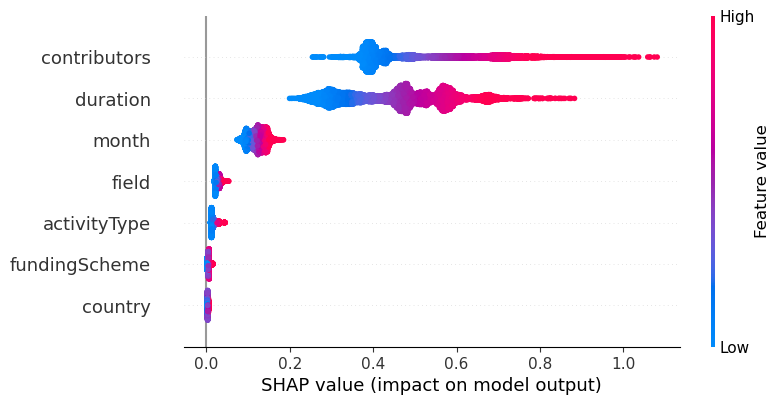

In [ ]:
shap_expl_grouped = shap.Explanation(
    values=grouped_shap_df.values,
    data=grouped_shap_df.values,  
    feature_names=grouped_shap_df.columns.tolist()
)

shap.plots.beeswarm(shap_expl_grouped, max_display=12)

In [48]:
print(shap_df.head)

<bound method NDFrame.head of        num__duration  num__contributors  num__month  \
0           0.516624           0.470384    0.128645   
1           0.451977           0.373276    0.142143   
2           0.520798           0.390401    0.151198   
3           0.465310           0.364456    0.146476   
4           0.499809           0.375796    0.135108   
...              ...                ...         ...   
12266       0.665882           0.388344    0.131451   
12267       0.697721           0.396678    0.082654   
12268       0.654301           0.403777    0.095985   
12269       0.706571           0.406873    0.112698   
12270       0.304657           0.361588    0.125914   

       num__agricultural sciences  num__engineering and technology  \
0                        0.003070                         0.014415   
1                        0.068250                         0.011598   
2                        0.003295                         0.011598   
3                        0.00

In [54]:
print(grouped_shap_df.mean())

duration         0.457783
contributors     0.497421
month            0.122743
field            0.027550
fundingScheme    0.005353
country          0.003443
activityType     0.016656
dtype: float64
